In [16]:
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

In [2]:
import os
import struct
 
def load_df(path, kind='train'):
    labels_path = os.path.join(path, '%s_labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s_images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2 # нормализация пикселей в диапазон [-1, 1]
 
    return images, labels

In [3]:
X_train, y_train = load_df('image_data', kind='train')
print('TRAIN df: Rows: %d, columns: %d' % (X_train.shape))

X_test, y_test = load_df('image_data', kind='test')
print('TEST  df: Rows: %d, columns: %d' % (X_test.shape))

# центрирование по среднему и нормализация
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_train, X_test
print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape,  y_test.shape)

TRAIN df: Rows: 60000, columns: 784
TEST  df: Rows: 10000, columns: 784
(60000, 784) (60000,)
(10000, 784) (10000,)


# Multilayer Neural Networks with TensorFlow

In [4]:
n_features = X_train_centered.shape[1]
n_classes = 10
random_seed = 123
np.random.seed(random_seed)

g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x = tf.placeholder(dtype=tf.float32,
                          shape=(None, n_features),
                          name='tf_x')

    tf_y = tf.placeholder(dtype=tf.int32, 
                          shape=None, name='tf_y')
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)

    h1 = tf.layers.dense(inputs=tf_x, units=50,    # 1 скрытый слой
                         activation=tf.tanh,
                         name='layer1')

    h2 = tf.layers.dense(inputs=h1, units=50,      # 2 скрытый слой
                         activation=tf.tanh,
                         name='layer2')

    logits = tf.layers.dense(inputs=h2, 
                             units=10,
                             activation=None,
                             name='layer3')

    predictions = {
        'classes'       : tf.argmax(logits, axis=1, name='predicted_classes'),
        'probabilities' : tf.nn.softmax(logits,     name='softmax_tensor')
    }

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [5]:
# определение функции издержек и операции оптимизации
with g.as_default():
    cost = tf.losses.softmax_cross_entropy(
            onehot_labels=y_onehot, logits=logits)

    optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=0.001)

    train_op = optimizer.minimize(loss=cost)

    init_op = tf.global_variables_initializer()

In [6]:
def create_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)
    
    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)
    
    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i:i+batch_size, :], y_copy[i:i+batch_size])

In [17]:
# Создание сессия для запуска графа
sess =  tf.Session(graph=g)
# инициализация переменных
sess.run(init_op)

# 15 итераций обучения
training_costs = []
for epoch in range(15):
    training_loss = []
    batch_generator = create_batch_generator(
            X_train_centered, y_train, 
            batch_size=64)
    for batch_X, batch_y in batch_generator:
        ## подготовка словаря для передачи данных се
        feed = {tf_x:batch_X, tf_y:batch_y}
        _, batch_cost = sess.run([train_op, cost],
                                 feed_dict=feed)
        training_costs.append(batch_cost)
    print(' ~~ %2d  '
          'средние потери при обучении: %.4f' % (
              epoch+1, np.mean(training_costs)
    ))

 ~~  1  средние потери при обучении: 1.5841
 ~~  2  средние потери при обучении: 1.2739
 ~~  3  средние потери при обучении: 1.1002
 ~~  4  средние потери при обучении: 0.9846
 ~~  5  средние потери при обучении: 0.9005
 ~~  6  средние потери при обучении: 0.8360
 ~~  7  средние потери при обучении: 0.7845
 ~~  8  средние потери при обучении: 0.7422
 ~~  9  средние потери при обучении: 0.7067
 ~~ 10  средние потери при обучении: 0.6764
 ~~ 11  средние потери при обучении: 0.6501
 ~~ 12  средние потери при обучении: 0.6271
 ~~ 13  средние потери при обучении: 0.6066
 ~~ 14  средние потери при обучении: 0.5884
 ~~ 15  средние потери при обучении: 0.5719


In [8]:
feed = {tf_x : X_test_centered}
y_pred = sess.run(predictions['classes'], feed_dict=feed)
acc = np.sum(y_pred == y_test)/len(y_test)
print(f'Правильность при испытании: {acc:.2%}')

Правильность при испытании: 91.24%


# Multilayer Neural Networks with Keras

In [9]:
import tensorflow.keras as keras

np.random.seed(123)
tf.set_random_seed(123)

In [10]:
y_train_onehot = keras.utils.to_categorical(y_train)
 
print('Превые 3 метки: ', y_train[:3])
print('\nПревые 3 метки (one-hot):\n', y_train_onehot[:3])

Превые 3 метки:  [5 0 4]

Превые 3 метки (one-hot):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [26]:
model = keras.models.Sequential()  # для NN прямого распространения 

model.add(  #  входной слой                              
    keras.layers.Dense(
        units=50,
        input_dim=X_train_centered.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(  #  1 скрытый слой
    keras.layers.Dense(
        units=50,
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(  #  2 скрытый слой
    keras.layers.Dense(
        units=y_train_onehot.shape[1],
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='softmax'))

sgd_optimizer = keras.optimizers.SGD(
    lr=0.001, decay=1e-7, momentum=.9)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [27]:
# функция потерь
model.compile(optimizer=sgd_optimizer, 
              loss='categorical_crossentropy')

In [12]:
history = model.fit(X_train_centered, y_train_onehot,
                    batch_size=64, epochs=50,
                    verbose=1, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 3s 58us/sample - loss: 0.7370 - val_loss: 0.3618
Epoch 2/50
54000/54000 [==============================] - 2s 41us/sample - loss: 0.3656 - val_loss: 0.2734
Epoch 3/50
54000/54000 [==============================] - 2s 43us/sample - loss: 0.2994 - val_loss: 0.2343
Epoch 4/50
54000/54000 [==============================] - 2s 39us/sample - loss: 0.2629 - val_loss: 0.2111
Epoch 5/50
54000/54000 [==============================] - 2s 38us/sample - loss: 0.2377 - val_loss: 0.1941
Epoch 6/50
54000/54000 [==============================] - 2s 41us/sample - loss: 0.2186 - val_loss: 0.1792
Epoch 7/50
54000/54000 [==============================] - 3s 51us/sample - loss: 0.2028 - val_loss: 0.1691
Epoch 8/50
54000/54000 [==============================] - 2s 43us/sample - loss: 0.1897 - val_loss: 0.1610
Epoch 9/50
54000/54000 [==============================] - 2s 40us/sample - loss: 0.1782 - val_l

In [19]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
print('Первые 3 прогноза: ', y_train_pred[:3])

Первые 3 прогноза:  [5 0 4]


In [14]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)

correct_preds = np.sum(y_train == y_train_pred, axis=0) 
train_acc = correct_preds / len(y_train)
print(f'Правильность при обучении: {train_acc:.2%}')

Правильность при обучении: 98.96%


In [15]:
y_test_pred = model.predict_classes(X_test_centered, verbose=0)

correct_preds = np.sum(y_test == y_test_pred, axis=0) 
test_acc = correct_preds / len(y_test)
print(f'Правильность при испытании: {test_acc:.2%}')

Правильность при испытании: 96.39%


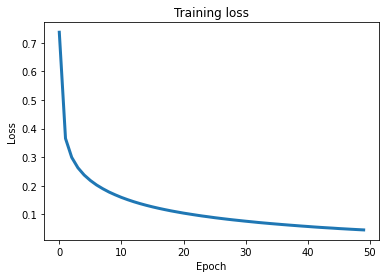

In [25]:
hist = history.history

plt.plot(hist['loss'], lw=3)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');